In [1]:
# save them to files so the workflow can run them

import os, sys, subprocess, pickle, random, toml
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import pickle

sys.path.append('../MOASMO_support')
from MOASMO_parameters import *


# Load basin info

basins and clusters match
[467 494 495 496 497 498 508 509 510 511 512 513 514 515 516 517 518 521
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 554 609 620 621 622 624 625 626]


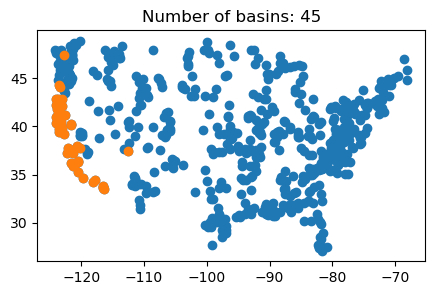

In [2]:
# load basin info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

# load cluster info
infile = "../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")


sel_cluster = 2
sel_index = df_cluster["clusters"].values == sel_cluster
basin_index = np.where(sel_index)[0]
print(basin_index)

plt.figure(figsize=[5, 3])
plt.scatter(df_info["lon_cen"], df_info["lat_cen"])
plt.scatter(df_info["lon_cen"].values[sel_index], df_info["lat_cen"].values[sel_index])
plt.title(f"Number of basins: {np.sum(sel_index)}")
plt.show()


# Load parameter sets

In [3]:
# file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_gpr_allbasin_cluster2_optmz_outputs.npz'
# d = np.load(file)
# bestx_sm_all_emu = d['bestx_sm_all_gpr']
# besty_sm_all_emu = d['besty_sm_all_gpr']


file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_rf_allbasin_cluster2_optmz_outputs.npz'
d = np.load(file)
bestx_sm_all_emu = d['bestx_sm_all_rf']
besty_sm_all_emu = d['besty_sm_all_rf']


# save parameters

In [4]:
num_per_iter = 40
n_sample = num_per_iter
iterflag = 0

numflag = 0

for b in basin_index:

    config_file = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO_bigrange/configuration/_level1-{b}_config_MOASMO.toml'
    config = toml.load(config_file)
    
    iter_end = 'iter1'
    
    # inputs
    param_infofile = config['file_calib_param']
    path_CTSM_case = config['path_CTSM_case']
    path_script_MOASMO = config['path_script_MOASMO']
    path_CTSM_source = config['path_CTSM_source']
    ref_streamflow = config['file_Qobs']
    path_MOASMOcalib = config['path_calib']

    path_paramset = f'{path_MOASMOcalib}/param_sets'
    path_submit = f'{path_MOASMOcalib}/run_model'
    path_archive = f'{path_MOASMOcalib}/ctsm_outputs'

    bestx_sm, besty_sm  = bestx_sm_all_emu[numflag], besty_sm_all_emu[numflag]
    numflag = numflag + 1
    
    # main
    outpath = path_paramset

    random.seed(1234567890)
    
    # check whether files have been generated
    flag = False
    for i in range(num_per_iter):
        outfile = f'{outpath}/paramset_iter{iterflag+1}_trial{i}.csv'
        if not os.path.isfile(outfile):
            flag = True
            break


    if flag == False:
        print('All parameter csv files have been generated. Skip this step')
    else:

        df_info = read_parameter_csv(param_infofile)


        xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
        xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])
        
        D = NSGA2.crowding_distance(besty_sm)
        print('model sample number:', D.shape[0])
        
        idxr = D.argsort()[::-1][:n_sample]
        x_resample = bestx_sm[idxr, :len(df_info)] # the attributes following the parameters are not needed
        y_resample = besty_sm[idxr, :]
        
        param_upper_bound = df_info['Upper'].values
        param_lower_bound = df_info['Lower'].values
        param_upper_bound_mean = np.array([np.nanmean(p) for p in param_upper_bound])
        param_lower_bound_mean = np.array([np.nanmean(p) for p in param_lower_bound])
        
        # load default parameter dataframe (file will be saved after first generation)
        df_defaultparam = read_save_load_all_default_parameters(param_infofile, outpath, path_CTSM_case)
        param0 = df_defaultparam['Value'].values


        # generate a parameter dataframe for next trial
        for i in range(x_resample.shape[0]):
            # outfile = f'{outpath}/paramset_iter{iterflag+1}_trial{i}.csv'
            outfile = f'{outpath}/paramset_iter{iterflag+1}_trial{i}.pkl'
            print('Generating parameter file:', outfile)

            dfi = df_info.copy()
            factors = (x_resample[i, :] - xlb_mean) / (xub_mean - xlb_mean)
            factors[factors<0] = 0.01
            factors[factors>1] = 0.99
            dfi['Factor'] = factors
            
            meanparam = factors * (param_upper_bound_mean - param_lower_bound_mean) + param_lower_bound_mean
            newparam =  [meanparam[j] / np.nanmean(param0[j]) * param0[j] for j in range(len(param0))]
            dfi['Value'] = newparam

            # process binded parameters
            dfi = check_and_generate_binded_parameters(dfi, path_CTSM_case)

            # write
            #dfi.to_csv(outfile, index=False)
            dfi.to_pickle(outfile)


model sample number: 100
Load default parameter values from: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_MOASMOcalib/param_sets/all_default_parameters.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_MOASMOcalib/param_sets/paramset_iter1_trial0.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_MOASMOcalib/param_sets/paramset_iter1_trial1.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_MOASMOcalib/param_sets/paramset_iter1_trial2.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_MOASMOcalib/param_sets/paramset_iter1_trial3.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/level1_467_